https://github.com/RadionBik/Statistical-estimator-of-network-traffic

## Original traffic characterization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
# sys.path.append("..")
from plotting import plot_stat_properties, goodput_dfs, hist_dfs, hist_2d_dfs
import stat_estimator as estimator
import hmm_helpers as hmm_h
import traffic_helpers as preprocessors
import matplotlib.pyplot as plt

all
Extracting flow features from traffic_dumps/skypeLANhome.pcap...
Extracting flow identifiers from traffic_dumps/skypeLANhome.pcap...
Found the following flows with # of packets > 100:
UDP 192.168.0.102:18826 192.168.0.105:26454 pkt number from: 3623
UDP 192.168.0.102:18826 192.168.0.105:26454 pkt number to: 3700
Finished extracting packet properties
Preparing histograms for the traffic...


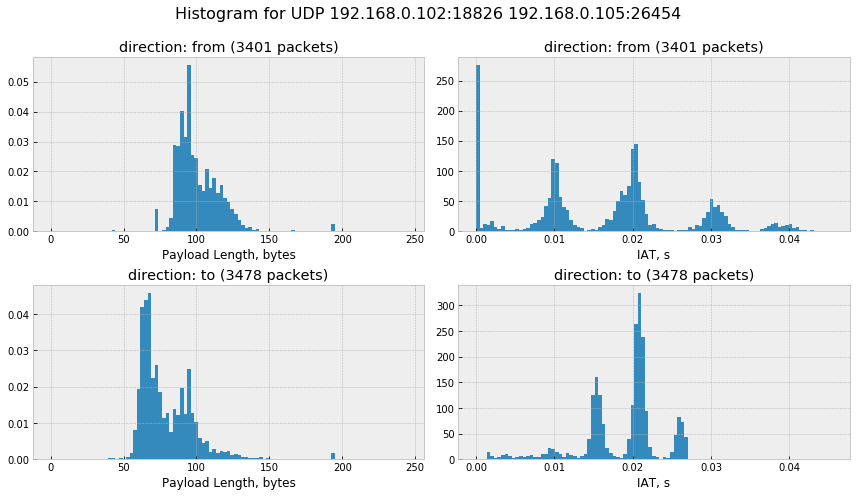

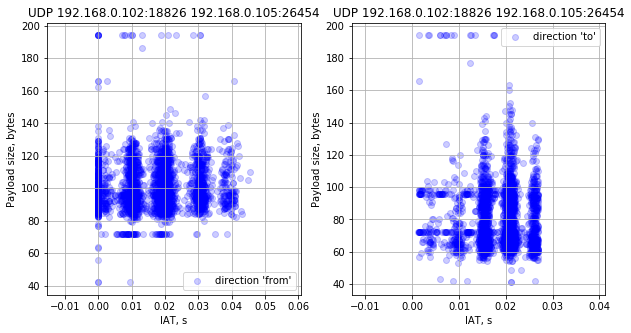

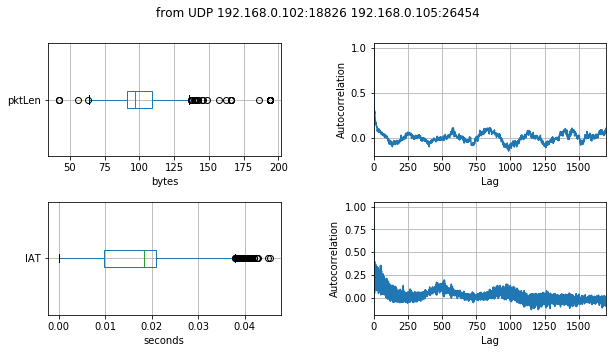

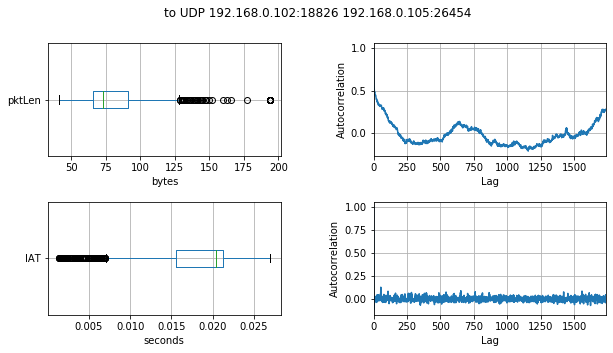

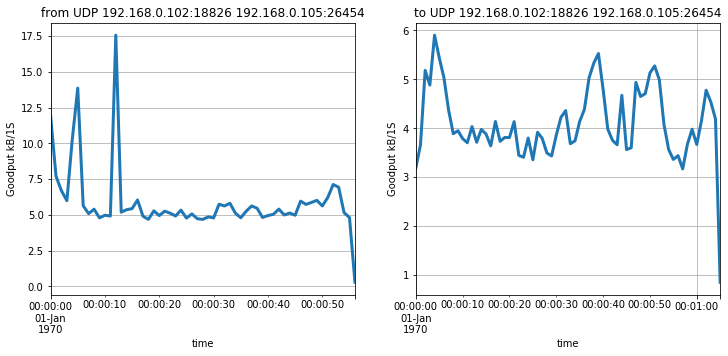

In [4]:
plt.rcParams['figure.figsize'] = [10, 5]

pcapfile = 'traffic_dumps/skypeLANhome.pcap'
traffic_dfs = estimator.getTrafficFeatures(pcapfile, 
                                           typeIdent='flow',
                                           fileIdent='all',
                                           percentiles=(3,97),
                                           min_samples_to_estimate=100)[0]
norm_traffic, scalers = preprocessors.normalize_dfs(traffic_dfs)
hist_dfs(traffic_dfs, logScale=0)
hist_2d_dfs(traffic_dfs, logScale=0)
plot_stat_properties(traffic_dfs)
goodput_orig = goodput_dfs(traffic_dfs, '1S')

## Train HMM, GMM and GMM-HMM models

1. Hidden Markov Model, the number of componenets is adjusted manually. The strategy is to use the highest possible
number of componets, however, in case of issues with training, it must be decreased.
2. Gaussian Mixture Model with Dirichlet distributed weights. The principle applies as above. See stat_estimator.py
for example of code adjusting componet number by Bayessian Information Criterion.
3. GMM-HMM. That is a HMM, where each component is modelled as a GMM. If transitions between components are of
importance, the general approach is to set more HMM states with fewer GMM components.

In [6]:
test_cases = ['HMM', 'GMM', 'HMM-GMM']
# test_cases = ['GMM']
comp_numb = 20
models = {}
for test_case in test_cases:
    print(f'-------- Started fitting {test_case} ---------')
    if test_case == 'HMM':
        models.update({test_case: hmm_h.get_hmm_gaussian_models(norm_traffic, comp_numb)})
    elif test_case == 'GMM':
        models.update({test_case: hmm_h.get_gmm(norm_traffic, comp_numb)})
    elif test_case == 'HMM-GMM':
        models.update({test_case: hmm_h.get_hmm_gmm(norm_traffic, 5, 2)})

-------- Started fitting HMM ---------
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "from"
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "to"
-------- Started fitting GMM ---------
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "from"
Best BIC is with 20 components
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "to"
Best BIC is with 20 components
-------- Started fitting HMM-GMM ---------
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "from"
Started fitting UDP 192.168.0.102:18826 192.168.0.105:26454 in direction "to"


## Characterize generated traffic

Preparing histograms for the traffic...


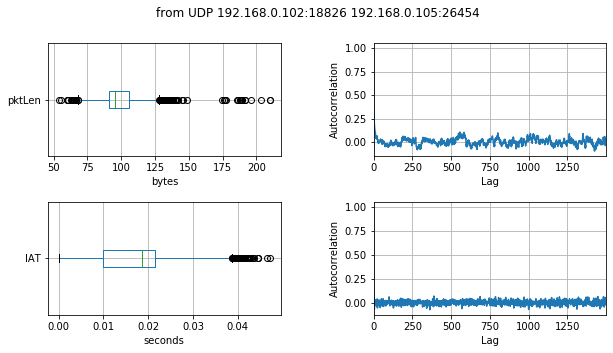

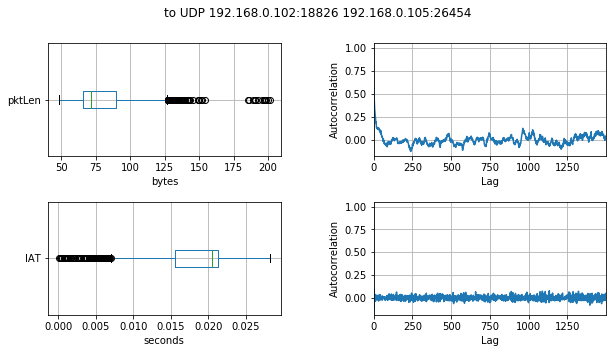

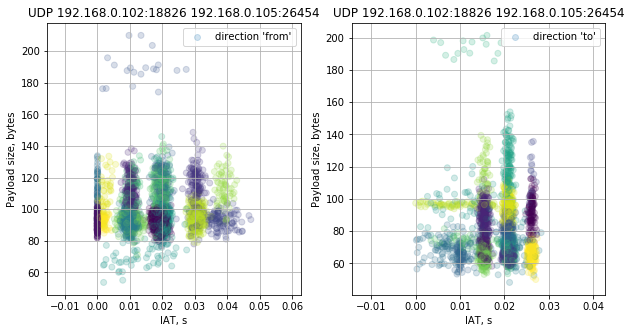

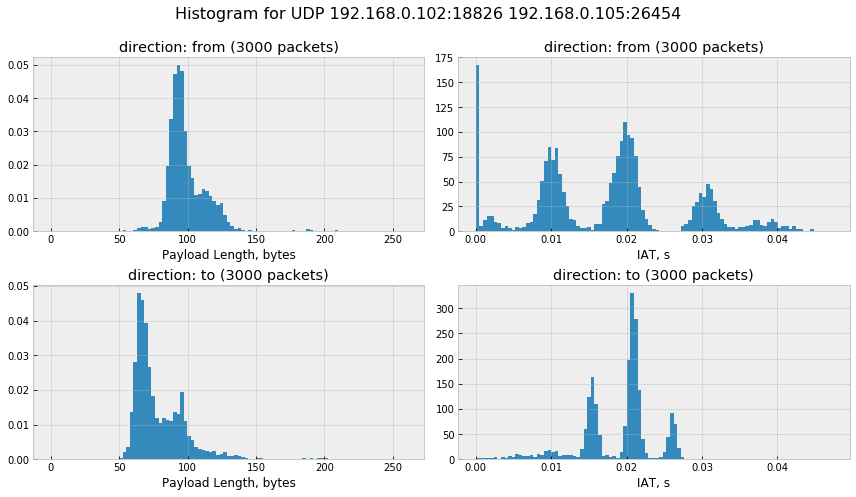

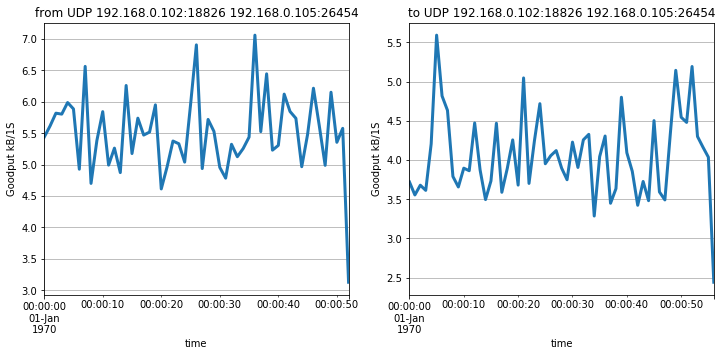

Preparing histograms for the traffic...


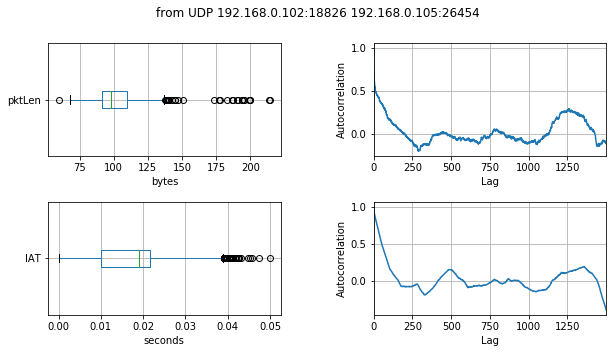

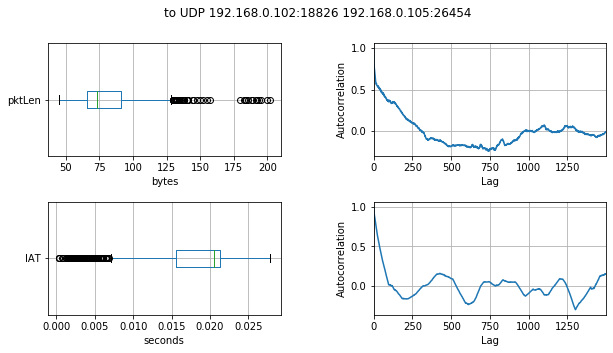

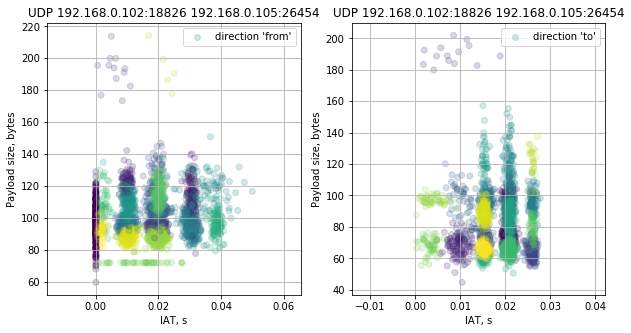

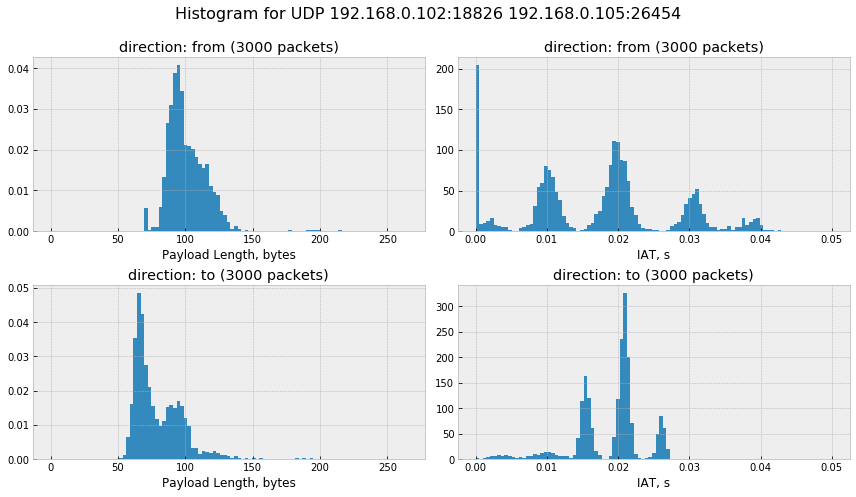

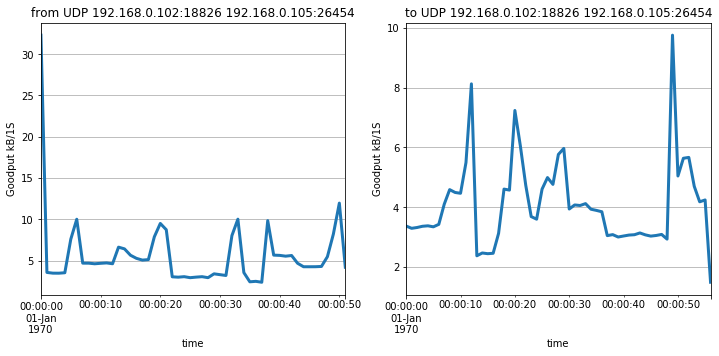

Preparing histograms for the traffic...


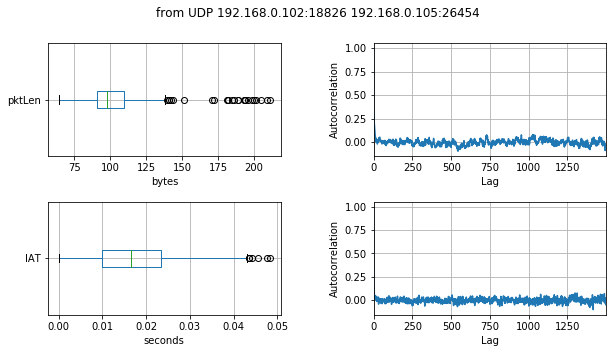

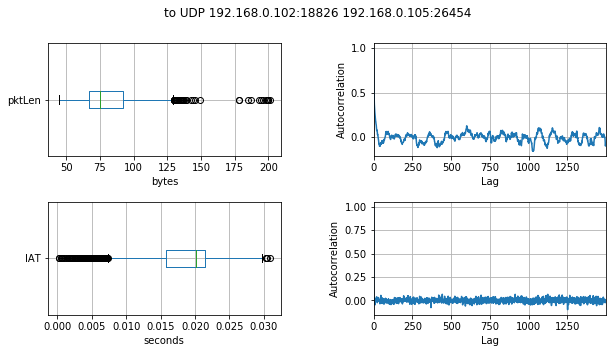

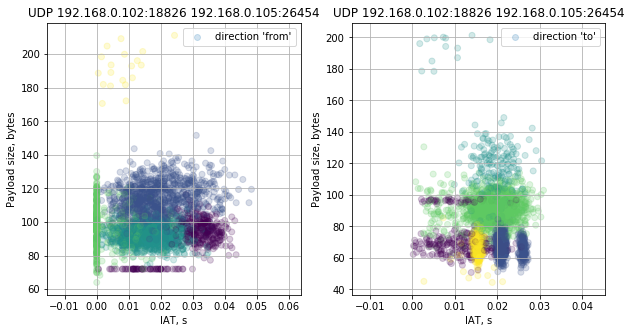

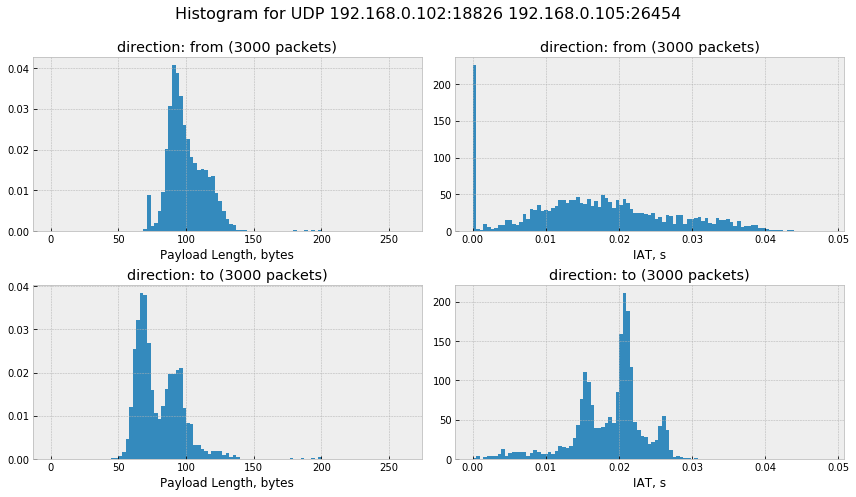

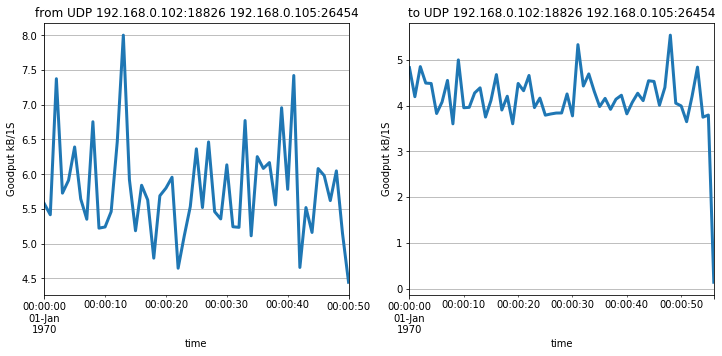

In [7]:
gener_dfs = {}
for model in models:
    # if model!='HMM':
    #    continue
    gener_df, states = hmm_h.gener_samples(models[model], scalers, 3000)
    plot_stat_properties(gener_df, saveToFile=model)
    hist_2d_dfs(gener_df, states=states, saveToFile=model)
    hist_dfs(gener_df, logScale=False, saveToFile=model)
    goodput_dfs(gener_df, saveToFile=model)
    gener_dfs.update({model: gener_df})

## Compare original and generated traffic statistics

In [8]:
import stat_tests as stat

for model in gener_dfs:
    print('Comparison of original distributions with {}:'.format(model))
    kl_divergences = stat.get_KL_divergence(traffic_dfs, gener_dfs[model])
    ks_tests = stat.get_ks_2sample_test(traffic_dfs, gener_dfs[model])
    qq_r = stat.get_qq_r_comparison(traffic_dfs, gener_dfs[model])
    # for device, direction, parameter, ks in iterate_traffic_3_layers(ks_tests):
    #    print(ks)

Comparison of original distributions with HMM:
Kulback-Leibler divergence:
UDP 192.168.0.102:18826 192.168.0.105:26454
            from        to
IAT     0.006377  0.005508
pktLen  0.040822  0.017020
Kolmogorov-Smirnov 2-sample test:
from UDP 192.168.0.102:18826 192.168.0.105:26454
                    IAT        pktLen
p-value    5.882632e-08  1.328491e-10
statistic  7.600000e-02  8.833333e-02
to UDP 192.168.0.102:18826 192.168.0.105:26454
                IAT        pktLen
p-value    0.290785  1.075869e-07
statistic  0.025333  7.466667e-02
Correlation of percentiles:
from:
IAT       0.986547
pktLen    0.991321
dtype: float64
to:
IAT       0.997545
pktLen    0.994223
dtype: float64


Comparison of original distributions with GMM:
Kulback-Leibler divergence:
UDP 192.168.0.102:18826 192.168.0.105:26454
            from        to
IAT     0.004633  0.001714
pktLen  0.029412  0.007507
Kolmogorov-Smirnov 2-sample test:
from UDP 192.168.0.102:18826 192.168.0.105:26454
                IAT    pk

## Conclusions

It appears that all models can model histogram properties well, given sufficient number of components. However,
HMM and HMM-GMM can reproduce time-series better than GMM due to  ability to handle transitions between components.
Moreover, HMM imitates original traffic closer than HMM-GMM with the same number of hidden variables.